In [1]:
!pip install -q keras
!pip install -q pandas
!pip install -q numpy
!pip install -q hyperopt
!pip install -q hyperas

In [3]:
!ls "/storage/log-analysis/"
import os
os.chdir("/storage/log-analysis/")

__pycache__  log_model-testing.h5  webLog.csv


In [32]:
#!/usr/bin/env python
"""
This file is for training on the webLog data.
"""

from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import  Model
from keras.layers import Dense, Input
import numpy as np
import pandas as pd

# Preprocess webLog.csv and get rid of the Time column.
log = '/storage/log-analysis/webLog.csv'
log = pd.read_csv(log)
log = log.drop(['Time'], axis=1)

samples = []
for row in log.iterrows():
    index, data = row
    samples.append(data.tolist())

max_words = 20000
maxlen = 3

# Tokenize values.
tokenizer = Tokenizer(num_words=max_words, lower=False)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

# Split data into training and test set. 
training_samples = int(len(samples) * 0.80)
test_samples = int(len(samples) * 0.20)

x = data[:training_samples]
x_test = data[training_samples: training_samples + test_samples]

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='log_model-testing.h5',
    monitor='val_loss',
    save_best_only=True
    )
]

# Create model.
input_dim = x.shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(2, activation='relu')(input)
encode = Dense(1, activation='relu')(encode)

decode = Dense(2, activation='relu')(encode)
decode = Dense(3, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])

# Train model.
history = autoencoder.fit(x, x,
        epochs=50,
        batch_size=32,
        callbacks=callbacks_list,
        validation_data=(x_test, x_test),
        shuffle=True
        )

Found 271 unique tokens.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 9         
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________
Train on 8630 samples, validate on 2157 samples
Epoch 1/50
8630/8630 [==============================] - 1s 77us/step - lo

In [33]:
import pandas as pd
from numpy import vstack

# Combined x and x_test.
new_x = vstack([x, x_test])

predictions = autoencoder.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# Set threshold at the 99th quartile.
threshold = error_df.quantile(0.99)

error_df.describe()

,reconstruction_error
count,10787.000000
mean,476.551456
std,1854.293671
min,8.670145
25%,32.675488
50%,85.676503
75%,246.017369
max,24300.489973


(array([10491.,   135.,    64.,    30.,    24.,    21.,    22.]),
 array([8.67014518e+00, 3.47893012e+03, 6.94919010e+03, 1.04194501e+04,
        1.38897100e+04, 1.73599700e+04, 2.08302300e+04, 2.43004900e+04]),
 <a list of 7 Patch objects>)

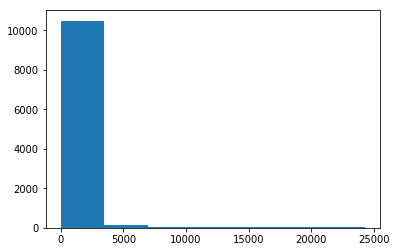

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

# Reconstruction error binned and plotted.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(error_df.reconstruction_error.values, bins=7)

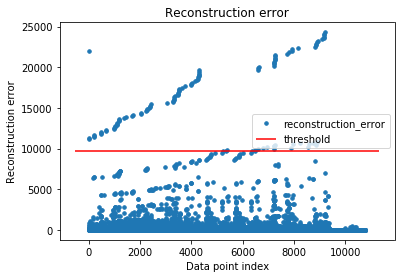

200
GET /madeup.php HTTP/1.1
10.4.5.2
----------------------------------
GET /profile.php?user=bala HTTP/1.1
10.130.2.1
200
----------------------------------
GET /edit.php?name=bala HTTP/1.1
10.131.2.1
200
----------------------------------
10.131.2.1
200
GET /contestproblem.php?name=Toph%20Contest%202 HTTP/1.1
----------------------------------
10.131.2.1
GET /details.php?id=3 HTTP/1.1
200
----------------------------------
10.131.2.1
200
GET /contestsubmission.php?id=4 HTTP/1.1
----------------------------------
10.131.2.1
200
GET /edit.php?name=ksrsingh HTTP/1.1
----------------------------------
200
GET /showcode.php?id=285&nm=ksrsingh HTTP/1.1
10.131.0.1
----------------------------------
GET /allsubmission.php?name=shawon HTTP/1.1
200
10.128.2.1
----------------------------------
200
10.129.2.1
GET /login.php HTTP/1.0
----------------------------------
10.131.2.1
302
GET / HTTP/1.0
----------------------------------
GET /profile.php?user=moshiur_cse15 HTTP/1.1
200
10.131.0.1
---

In [35]:
threshold = threshold

# Plot reconstruction error vs. the data.
fig, ax = plt.subplots()
ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='threshold')
ax.legend(loc=5)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Output anomalies.
index_list = []
for index, row in error_df.iterrows():
    if row.reconstruction_error > int(threshold):
        index_list.append(index)

output = []    
for x in index_list:
    output.append(new_x[x])
  
for x in output:
    for key, value in word_index.items():
        if value == x[2]:
            print(key)
        if value == x[1]:
            print(key)
        if value == x[0]:
            print(key)
    print('----------------------------------')


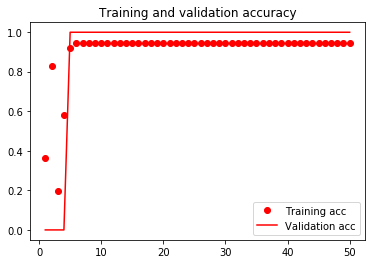

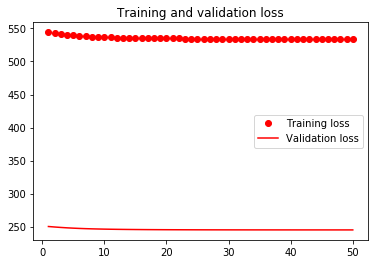

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1 , len(acc) + 1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()